In [1]:
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

from HeatEqFDM import heat_equation
from HeatEqPINN import heat_equation_NN

# FDM Process

In [2]:
# Initialize Meshgrid
x = np.linspace(0,1,100)
X,Y = np.meshgrid(x,x)
T = np.linspace(0,10,100)
HE = heat_equation(X,Y,T)

#Initialize Initial Condition
norm = lambda x, xmin = 273, xmax = 473: (x-xmin)/(xmax-xmin)
init_heat = np.zeros((100,100)) + norm(273)
init_heat[0,:] = norm(373)
init_heat[:,0] = norm(473)

HE.initial_temp(init_heat)

#Initialize Boundary Condition
bound_temp = [norm(373), norm(273), norm(473), norm(273)]

HE.time_array(100,1)

#Solve the Equation and Turn to GIF
HE.solve_heat(bound_temp = bound_temp, neumann = False)
HE.save()

# PINN Process

In [2]:
#Spatial Domain
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
#Temporal Domain
t = np.linspace(0,10,100)

X,Y = np.meshgrid(x,y)
T = np.tile(t, 100)

#Initiate Normalized Initial Condition
norm = lambda x, xmin = 273, xmax = 473: (x-xmin)/(xmax-xmin)
U_INIT = np.zeros((100, 100)) + norm(273)
U_INIT[:,0] = norm(473) #LEFT INIT
U_INIT[:,-1] = norm(273) #RIGHT INIT
U_INIT[0,:] = norm(373) #LOWER INIT
U_INIT[-1,:] = norm(273) #UPPER INIT
X_INIT, Y_INIT = np.meshgrid(x,y)
T_INIT = np.zeros_like(X_INIT)

#Initiate Normalized Boundary Condition
#Left BC U = 473 U(0,y,t)
u_left = np.zeros(100)+norm(473)
x_left = X[:,0]; y_left = Y[:,0]
#Right BC U = -20 U(-1,y,t)
u_right = np.zeros(100)+norm(273)
x_right = X[:,-1]; y_right = Y[:,-1]
#Lower BC U = 373 U(x,0,t)
u_lower = np.zeros(100)+norm(373)
x_lower = X[0,:]; y_lower = Y[0,:]
#Upper BC U = -50 U(x,0,t)
u_upper = np.zeros(100)+norm(273)
x_upper = X[-1,:]; y_upper = Y[-1,:]
#Concat each boundary condition into one
U_BOUNDS = np.c_[u_left, u_right, u_lower, u_upper]
X_BOUNDS = np.c_[x_left, x_right, x_lower, x_upper]
Y_BOUNDS = np.c_[y_left, y_right, y_lower, y_upper]
T_BOUNDS = np.tile(t,4)

In [3]:
#Assign point to HENN class
HENN = heat_equation_NN(X,Y,T)
#Initiate nn_model
HENN.nn_model(layers = [128,64,64,64,1])
#Assign Initial and Boundary Condition
HENN.init_value(X_INIT, Y_INIT, U_INIT, T_INIT)
HENN.init_bound(X_BOUNDS, Y_BOUNDS, U_BOUNDS, T_BOUNDS, neumann = False)
HENN.train_step(3000, print_step = 100)

2024-07-10 13:32:56.238082: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 13:32:57.792061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 57569 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0


2024-07-10 13:33:02.611746: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch: 0 Loss: 1.2870
Epoch: 100 Loss: 0.0897
Epoch: 200 Loss: 0.0805
Epoch: 300 Loss: 0.0588
Epoch: 400 Loss: 0.0334
Epoch: 500 Loss: 0.0251
Epoch: 600 Loss: 0.0208
Epoch: 700 Loss: 0.0194
Epoch: 800 Loss: 0.0162
Epoch: 900 Loss: 0.0149
Epoch: 1000 Loss: 0.0172
Epoch: 1100 Loss: 0.0131
Epoch: 1200 Loss: 0.0123
Epoch: 1300 Loss: 0.0124
Epoch: 1400 Loss: 0.0117
Epoch: 1500 Loss: 0.0104
Epoch: 1600 Loss: 0.0136
Epoch: 1700 Loss: 0.0091
Epoch: 1800 Loss: 0.0084
Epoch: 1900 Loss: 0.0095
Epoch: 2000 Loss: 0.0072
Epoch: 2100 Loss: 0.0067
Epoch: 2200 Loss: 0.0063
Epoch: 2300 Loss: 0.0060
Epoch: 2400 Loss: 0.0065
Epoch: 2500 Loss: 0.0054
Epoch: 2600 Loss: 0.0051
Epoch: 2700 Loss: 0.0049
Epoch: 2800 Loss: 0.0048
Epoch: 2900 Loss: 0.0063


In [4]:
x_new = np.linspace(0,1,100).reshape(-1,1)
y_new = np.linspace(0,1,100).reshape(-1,1)
X_new, Y_new = np.meshgrid(x_new, y_new)

T_new = np.linspace(0,10,100)

HENN.predict(X_new, Y_new, T_new)
HENN.save()

Frame 0 Done!
Frame 10 Done!
Frame 20 Done!
Frame 30 Done!
Frame 40 Done!
Frame 50 Done!
Frame 60 Done!
Frame 70 Done!
Frame 80 Done!
Frame 90 Done!


# Combining Both Results

In [3]:
FDM = np.load('HeatEqFDM.npy')
PINN = np.load('HeatEqPINN.npy')

MovieWriter Pillow unavailable; using Pillow instead.


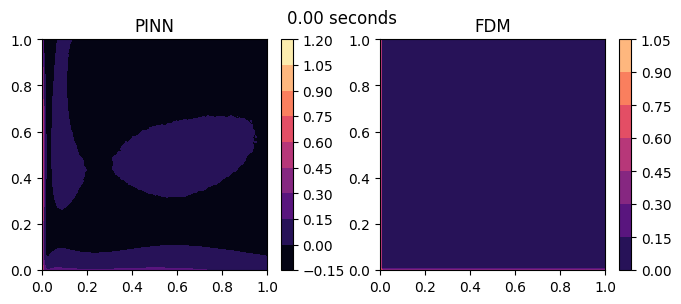

In [6]:
#Set Figure and minimum/maximum value
fig, ax = plt.subplots(1,2, figsize = (8,3))
PINN_min = PINN.min(); PINN_max = PINN.max()
FDM_min = FDM.min(); FDM_max = FDM.max()

#Initate the first contour
PINNc = ax[0].contourf(X, Y, PINN[0], vmin=PINN_min, vmax=PINN_max,
                             cmap = 'magma')
ax[0].set_title('PINN')
    
FDMc = ax[1].contourf(X, Y, FDM[0], vmin=PINN_min, vmax=PINN_max,
                             cmap = 'magma')
ax[1].set_title('FDM')
    
fig.suptitle(0)
PINNbar = plt.colorbar(PINNc, ax=ax[0])
FDMbar = plt.colorbar(FDMc, ax=ax[1])

#Declare update function to update frames of each axes
def update(frame):
    ax[0].clear(); ax[1].clear()
    
    PINNc = ax[0].contourf(X, Y, PINN[frame], vmin=PINN_min, vmax=PINN_max,
                             cmap = 'magma')
    ax[0].set_title('PINN')
    
    FDMc = ax[1].contourf(X, Y, FDM[frame], vmin=PINN_min, vmax=PINN_max,
                             cmap = 'magma')
    ax[1].set_title('FDM')
    
    fig.suptitle(f'{frame*.1:.2f} seconds')
    return PINNc, FDMc
        
num_frames = PINN.shape[0]
ani = FuncAnimation(fig, update, frames=num_frames, interval=100)
ani.save('CompareAnimation.gif', writer='Pillow', fps=10)